In [1]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap

from matplotlib import cm
import numpy as np
import pandas as pd

In [2]:
print
ff1.Cache.enable_cache('../cache')

plotting.setup_mpl()

/Users/chinmaybansal/.pyenv/versions/3.11.9/lib/python3.11/site-packages/fastf1/plotting/_plotting.py:90: FutureWarning: FastF1 will no longer silently modify the default Matplotlib colors in the future.
To remove this warning, explicitly set `color_scheme=None` or `color_scheme='fastf1'` when calling `.setup_mpl()`.
  warnings.warn(
/Users/chinmaybansal/.pyenv/versions/3.11.9/lib/python3.11/site-packages/fastf1/plotting/_plotting.py:98: FutureWarning: FastF1 will stop modifying the default Matplotlib settings in the future.
To opt-in to the new behaviour and remove this warning, explicitly set `misc_mpl_mods=False` when calling `.setup_mpl()`.
  warnings.warn(


In [13]:
# Load the qualifying session for the 2021 Abu Dhabi GP
quali = ff1.get_session(2021, 'Abu Dhabi', 'R')

# Load session data with laps and telemetry
quali.load(laps=True, telemetry=True)

# Access the laps data
laps = quali.laps  # or laps = quali.load_laps()

core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.4.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data

In [14]:
laps_ver = laps.pick_driver('VER')
laps_ham = laps.pick_driver('HAM')

# Get the telemetry data from their fastest lap
fastest_ver = laps_ver.pick_fastest().get_telemetry().add_distance()
fastest_ham = laps_ham.pick_fastest().get_telemetry().add_distance()

# Since the telemetry data does not have a variable that indicates the driver, 
# we need to create that column
fastest_ver['Driver'] = 'VER'
fastest_ham['Driver'] = 'HAM'

# Merge both lap telemetries so we have everything in one DataFrame
telemetry = pd.concat([fastest_ver, fastest_ham], ignore_index=True)

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


In [15]:
print(fastest_ver[['X', 'Y', 'Z']].dtypes)
print(fastest_ham[['X', 'Y', 'Z']].dtypes)

# Convert integer columns to float
fastest_ham[['X', 'Y', 'Z']] = fastest_ham[['X', 'Y', 'Z']].astype(float)
print(fastest_ver[['X', 'Y', 'Z']].dtypes)
print(fastest_ham[['X', 'Y', 'Z']].dtypes)

X    int64
Y    int64
Z    int64
dtype: object
X    float64
Y    float64
Z    float64
dtype: object
X    int64
Y    int64
Z    int64
dtype: object
X    float64
Y    float64
Z    float64
dtype: object


In [16]:
# We want 25 mini-sectors (this can be adjusted up and down)
num_minisectors = 25

# Grab the maximum value of distance that is known in the telemetry
total_distance = total_distance = max(telemetry['Distance'])

# Generate equally sized mini-sectors 
minisector_length = total_distance / num_minisectors

In [17]:

# Initiate minisector variable, with 0 (meters) as a starting point.
minisectors = [0]

# Add multiples of minisector_length to the minisectors
for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

In [18]:
telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) + 1)
    )
)

In [19]:
# Calculate avg. speed per driver per mini sector
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()
print(average_speed)

    Minisector Driver       Speed
0            1    HAM  257.148148
1            1    VER  254.962963
2            2    HAM  210.903226
3            2    VER  221.833333
4            3    HAM  209.451613
5            3    VER  204.000000
6            4    HAM  257.269231
7            4    VER  258.076923
8            5    HAM  270.250000
9            5    VER  275.000000
10           6    HAM  289.608696
11           6    VER  287.590909
12           7    HAM  167.850000
13           7    VER  170.800000
14           8    HAM  187.228571
15           8    VER  188.971429
16           9    HAM  268.200000
17           9    VER  268.958333
18          10    HAM  294.818182
19          10    VER  292.136364
20          11    HAM  306.190476
21          11    VER  303.043478
22          12    HAM  307.363636
23          12    VER  300.285714
24          13    HAM  117.035088
25          13    VER  119.421053
26          14    HAM  188.411765
27          14    VER  184.205882
28          15

In [20]:
# Select the driver with the highest average speed
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]

# Get rid of the speed column and rename the driver column
fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})
print(fastest_driver)

    Minisector Fastest_driver
0            1            HAM
3            2            VER
4            3            HAM
7            4            VER
9            5            VER
10           6            HAM
13           7            VER
15           8            VER
17           9            VER
18          10            HAM
20          11            HAM
22          12            HAM
25          13            VER
26          14            HAM
28          15            HAM
30          16            HAM
32          17            HAM
35          18            VER
37          19            VER
38          20            HAM
41          21            VER
43          22            VER
44          23            HAM
47          24            VER
49          25            VER
50          26            HAM


In [21]:
# Join the fastest driver per minisector with the full telemetry
telemetry = telemetry.merge(fastest_driver, on=['Minisector'])

# Order the data by distance to make matploblib does not get confused
telemetry = telemetry.sort_values(by=['Distance'])

# Convert driver name to integer
telemetry.loc[telemetry['Fastest_driver'] == 'VER', 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == 'HAM', 'Fastest_driver_int'] = 2


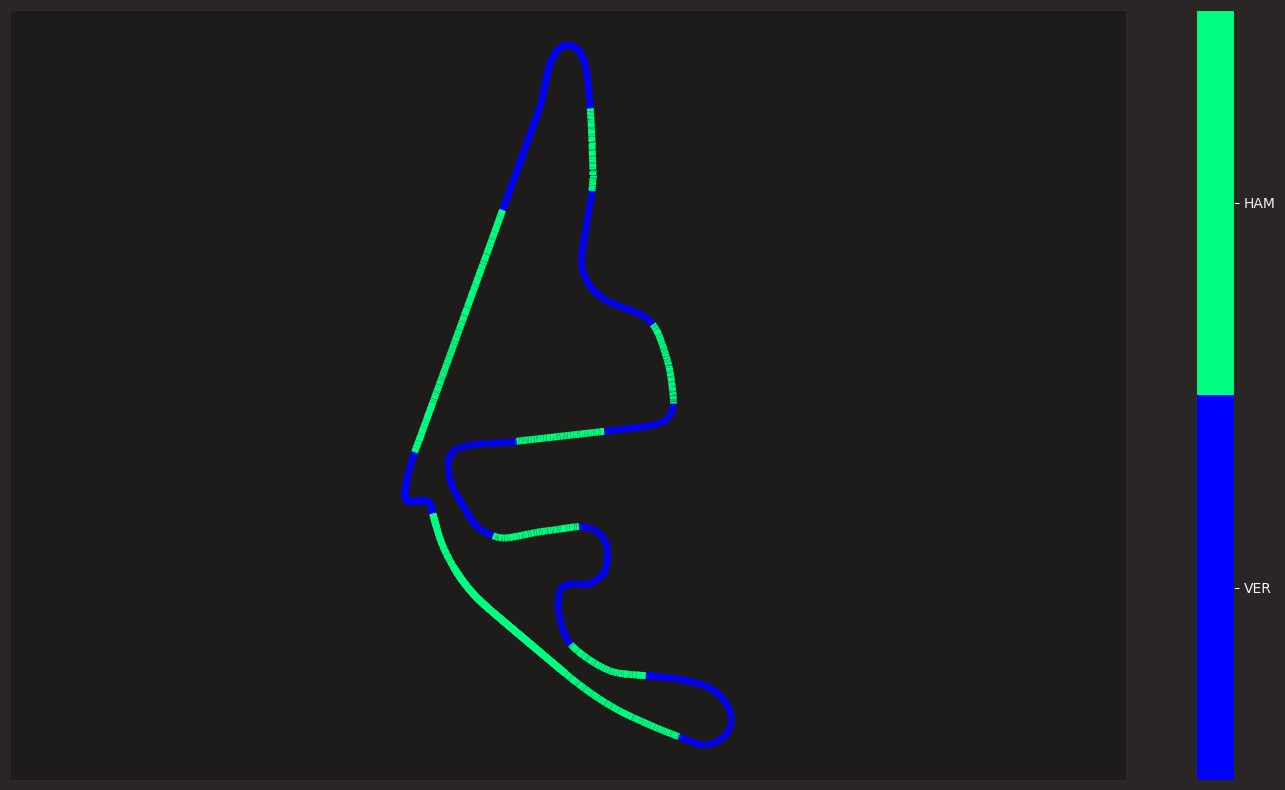

In [22]:
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

# Get the base colormap
base_cmap = plt.colormaps.get_cmap('winter')

# Create a colormap with two discrete colors
cmap = ListedColormap(base_cmap(np.linspace(0, 1, 2)))

lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N + 1), cmap=cmap)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(5)

plt.rcParams['figure.figsize'] = [18, 10]

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

# Set the colorbar with two ticks for two drivers
cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1, 4))
cbar.set_ticks([1.5, 2.5])  # Match the number of ticks with the number of labels
cbar.set_ticklabels(['VER', 'HAM'])

plt.savefig("2021_ver_ham_q.png", dpi=300)

plt.show()